# <center>Model Interpretability on Random Forest using SHAP</center>

## Table of Contents

1. [Problem Statement](#section1)<br><br>
2. [Importing Packages](#section2)<br><br>
3. [Loading Data](#section3)
  - 3.1 [Description of the Dataset](#section301)<br><br>
4. [Data Preprocessing](#section4)<br><br>
5. [Data train/test split](#section5)<br><br>
6. [Random Forest Model](#section6)
  - 6.1 [Random Forest in scikit-learn](#section601)<br><br>  
  - 6.2 [Using the Model for Prediction](#section602)<br><br>
7. [Model Evaluation](#section7)
   - 7.1 [Accuracy Score](#section701)<br><br>
8. [Model Interpretability using SHAP](#section8)   
  - 8.1 [Explain predictions](#section801)<br><br>
  - 8.2 [Visualize a single prediction](#section802)<br><br>
  - 8.3 [Visualize many predictions](#section803)<br><br>
  - 8.4 [SHAP Dependence Plots](#section804)<br><br>
  - 8.5 [SHAP Summary Plot](#section805)<br><br>
  - 8.6 [Bar chart of Mean Importance](#section806)<br>

<a id=section1></a>
## 1. Problem Statement


- We have often found that **Machine Learning (ML)** algorithms capable of capturing **structural non-linearities** in training data - models that are sometimes referred to as **'black box' (e.g. Random Forests, Deep Neural Networks, etc.)** - perform far **better at prediction** than their **linear counterparts (e.g. Generalised Linear Models)**. 


- They are, however, much **harder to interpret** - in fact, quite often it is **not possible to gain any insight into why a particular prediction has been produced**, when given an **instance of input data (i.e. the model features)**. 


- Consequently, it has **not been possible to use 'black box' ML algorithms** in situations where clients have sought **cause-and-effect explanations for model predictions**, with end-results being that sub-optimal predictive models have been used in their place, as their explanatory power has been more valuable, in relative terms.


- The **problem with model explainability** is that it’s **very hard to define a model’s decision boundary in human understandable manner**. 


- **SHAP (SHapley Additive exPlanations)** is a unified approach to **explain the output of any machine learning model**.

<br>
<img src="../../images/shap.png" width="700" height="400"/> <br><br>


- We will use **SHAP** to **interpret** our **RandomForest model**.

---

<a id=section2></a>
## 2. Importing Packages

In [ ]:
# Install SHAP using the following command.

!pip install shap

In [1]:
import numpy as np
np.set_printoptions(precision=4)                    # To display values only upto four decimal places. 

import pandas as pd
pd.set_option('mode.chained_assignment', None)      # To suppress pandas warnings.
pd.set_option('display.max_colwidth', -1)           # To display all the data in the columns.
pd.options.display.max_columns = 40                 # To display all the columns. (Set the value to a high number)

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')                  # To apply seaborn whitegrid style to the plots.
plt.rc('figure', figsize=(10, 8))                   # Set the default figure size of plots.
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')                   # To suppress all the warnings in the notebook.

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

---

<a id=section3></a>
## 3. Loading Data

In [2]:
df = pd.read_csv('../../data/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


<a id=section301></a>
### 3.1 Description of the Dataset

- This **dataset includes descriptions** of hypothetical samples corresponding to **23 species** of **gilled mushrooms** in the **Agaricus and Lepiota Family Mushroom** drawn from **The Audubon Society Field Guid**e to **North American Mushrooms (1981)**. 


- **Each species** is **identified as definitely edible**, **definitely poisonous**, or **of unknown edibility** and **not recommended**. This **latter class was combined with** the **poisonous one**. 


- The **Guide clearly states** that there is no **simple rule for determining** the **edibility of a mushroom**; no rule like **"leaflets three, let it be''** for **Poisonous Oak and Ivy**.

In [3]:
df.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

| **Column Name**                  | **Description**                                                                          |
| ---------------------------------|:----------------------------------------------------------------------------------------:| 
| class                            | classes: edible=e, poisonous=p.                                                          |
| cap-shape                        | bell=b,conical=c, convex=x, flat=f, knobbed=k, sunken=s.                                 |
| cap-surface                      | fibrous=f, grooves=g, scaly=y, smooth=s.                                                 |
| cap-color                        | brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y.|
| bruises                          | bruises=t, no=f.                                                                         |
| odor                             | almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m ,none=n, pungent=p, spicy=s.     |
| gill-attachment                  | attached=a, descending=d, free=f, notched=n.                                             |
| gill-spacing                     | close=c, crowded=w, distant=d.                                                           |
| gill-size                        | broad=b, narrow=n.                                                                       |
| gill-color                       | black=k, brown=n ,buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y.                                                                                                            |
| stalk-shape                      | enlarging=e, tapering=t.                                                                 |
| stalk-root                       | bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?.                   |
| stalk-surface-above-ring         | fibrous=f, scaly=y, silky=k, smooth=s.                                                   |
| stalk-surface-below-ring         | fibrous=f, scaly=y, silky=k, smooth=s.                                                   |
| stalk-color-above-ring           | brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y.         |
| stalk-color-below-ring           | brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y.         |
| veil-type                        | partial=p ,universal=u.                                                                  |
| veil-color                       | brown=n, orange=o, white=w, yellow=y.                                                    |
| ring-number                      | none=n, one=o, two=t.                                                                    |
| ring-type                        | cobwebby=c, evanescent=e, flaring=f, large=l, none=n, pendant=p, sheathing=s, zone=z.    |
| spore-print-color                | black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y.   |
| population                       | abundant=a, clustered=c, numerous=n, scattered=s, several=v, solitary=y.                 |
| habitat                          | grasses=g, leaves=l, meadows=m, paths=p, urban=u, waste=w, woods=d.                      |

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

In [5]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


---

<a id=section4></a>
## 4. Data Preprocessing

In [6]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [7]:
# Creating labels array from the class column.

labels = df.iloc[:, 0].values
labels

array(['p', 'e', 'e', ..., 'e', 'p', 'e'], dtype=object)

In [8]:
# Creating a LabelEncoder object le and fitting labels array into it.

le = LabelEncoder()
le.fit(labels)

LabelEncoder()

In [9]:
# Transforming the labels array to have numerical values.

labels = le.transform(labels)
labels

array([1, 0, 0, ..., 0, 1, 0])

In [10]:
# Storing the different classes found by LabelEncoder in labels array into class_names.

class_names = le.classes_
class_names

array(['e', 'p'], dtype=object)

In [11]:
# Dropping the class column from the df dataframe.

df.drop(['class'], axis=1, inplace=True)

In [12]:
df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [13]:
# We expand the characters into words, using the dataset description provided in the beginning.

categorical_names = '''bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
fibrous=f,grooves=g,scaly=y,smooth=s
brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
bruises=t,no=f
almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
attached=a,descending=d,free=f,notched=n
close=c,crowded=w,distant=d
broad=b,narrow=n
black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
enlarging=e,tapering=t
bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
fibrous=f,scaly=y,silky=k,smooth=s
fibrous=f,scaly=y,silky=k,smooth=s
brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
partial=p,universal=u
brown=n,orange=o,white=w,yellow=y
none=n,one=o,two=t
cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d'''.split('\n')

categorical_names[0]

'bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s'

In [14]:
for j, names in enumerate(categorical_names):
    values = names.split(',')
    values = dict([(x.split('=')[1], x.split('=')[0]) for x in values])
    df.iloc[:, j] = df.iloc[:, j].map(values)

In [15]:
df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,convex,smooth,yellow,bruises,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,bell,smooth,white,bruises,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,convex,scaly,white,bruises,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


In [16]:
df_display = df.copy()

In [17]:
df_display.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,convex,smooth,yellow,bruises,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,bell,smooth,white,bruises,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,convex,scaly,white,bruises,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


In [18]:
# Creating a range form 0 upto the number of categorical features. Since all the features in df are categorical using len(). 

categorical_features = range(len(df.columns))
categorical_features

range(0, 22)

In [19]:
# LabelEncoding all the features. Capturing the different class values for each feature in the categorical_names dictionary.

categorical_names = {}

for feature in categorical_features:
    le = LabelEncoder()
    le.fit(df.iloc[:, feature])
    df.iloc[:, feature] = le.transform(df.iloc[:, feature])
    categorical_names[feature] = le.classes_

In [20]:
categorical_names[0]

array(['bell', 'conical', 'convex', 'flat', 'knobbed', 'sunken'],
      dtype=object)

---

<a id=section5></a>
## 5. Data train/test split

- Now that the entire **data** is of **numeric datatype**, lets begin our modelling process.


- Firstly, **splitting** the complete **dataset** into **training** and **testing** datasets.

In [137]:
df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,2,3,0,0,7,1,0,1,0,0,2,3,3,7,7,0,2,1,4,0,3,4
1,2,3,9,0,0,1,0,0,0,0,1,3,3,7,7,0,2,1,4,1,2,0
2,0,3,8,0,1,1,0,0,1,0,1,3,3,7,7,0,2,1,4,1,2,2
3,2,2,8,0,7,1,0,1,1,0,2,3,3,7,7,0,2,1,4,0,3,4
4,2,3,3,1,6,1,1,0,0,1,2,3,3,7,7,0,2,1,0,1,0,0


In [139]:
X = df.iloc[:, :]
X.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,2,3,0,0,7,1,0,1,0,0,2,3,3,7,7,0,2,1,4,0,3,4
1,2,3,9,0,0,1,0,0,0,0,1,3,3,7,7,0,2,1,4,1,2,0
2,0,3,8,0,1,1,0,0,1,0,1,3,3,7,7,0,2,1,4,1,2,2
3,2,2,8,0,7,1,0,1,1,0,2,3,3,7,7,0,2,1,4,0,3,4
4,2,3,3,1,6,1,1,0,0,1,2,3,3,7,7,0,2,1,0,1,0,0


In [140]:
y = labels[:]
y[:10]

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [141]:
# Using scikit-learn's train_test_split function to split the dataset into train and test sets.
# 80% of the data will be in the train set and 20% in the test set, as specified by test_size=0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
# Checking the shapes of all the training and test sets for the dependent and independent features.

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6499, 22)
(6499,)
(1625, 22)
(1625,)


---

<a id=section6></a>
## 6.  Random Forest Model

<a id=section601></a>
### 6.1  Random Forest with Scikit-Learn

In [144]:
# Creating a Random Forest Classifier.

classifier_rf = RandomForestClassifier(n_estimators=200, random_state=0, oob_score=True, n_jobs=-1)

In [145]:
# Fitting the model on the dataset.

classifier_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [146]:
classifier_rf.oob_score_

1.0

- From the **OOB score** we can see how our model's gonna perform against the **test set or new** samples.

---

<a id=section602></a>
### 6.2 Using the Model for Prediction

In [147]:
# Making predictions on the training set.

y_pred_train = classifier_rf.predict(X_train)
y_pred_train[:10]

array([1, 1, 1, 0, 0, 1, 0, 0, 1, 1])

In [148]:
# Making predictions on test set.

y_pred_test = classifier_rf.predict(X_test)
y_pred_test[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 0, 0])

---

<a id=section7></a>
## 7. Model Evaluation

**Error** is the deviation of the values predicted by the model with the true values.

<a id=section701></a>
### 7.1 Accuracy Score

In [149]:
# Accuracy score on the training set.

print('Accuracy score for train data is:', accuracy_score(y_train, y_pred_train))

Accuracy score for train data is: 1.0


In [150]:
# Accuracy score on the test set.

print('Accuracy score for test data is:', accuracy_score(y_test, y_pred_test))

Accuracy score for test data is: 1.0


- We get an **accuracy** of **100%** on our train set and an **accuracy** of **100%** on our test set.


- We can notice that the **accuracy** obtained on the **test set (1.0)** is similar to the one obtained using the **oob_score_ (1.0)**, so we can use the **oob_score_** as a **validation** before testing our model on the **test set**. 

<a id=section8></a>
## 8. Model Interpretability using SHAP


- **SHAP (SHapley Additive exPlanations)** is a unified approach to **explain the output of any machine learning model**. 


- **SHAP connects game theory with local explanations**, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations. 

In [63]:
import shap

In [64]:
# Load JS visualization code to notebook

shap.initjs()

<a id=section801></a>
### 8.1 Explain predictions

In [151]:
# Explain the model's predictions using SHAP values 

explainer = shap.TreeExplainer(classifier_rf)

In [152]:
# Calculating the SHAP values for the entire dataset. Alternately X_train or X_test can be used instead of df.

shap_values = explainer.shap_values(df)

In [154]:
# The shap_values consists of SHAP values with respect to both the classes 0 and 1 having an output value 1.00
# We only need to use SHAP values with respect to one class for visualization.
# Creating shap_values_1 which is an array of SHAP values where class 1 (i.e. Poisonous) have an output value of 1.00
# and class 0 (i.e. Edible) have an output value of 0.00

shap_values_1 = np.array(shap_values)[1]
shap_values_1.shape

(8124, 22)

<a id=section802></a>
### 8.2 Visualize a single prediction

In [155]:
# Visualizing the first row's prediction's explanation

shap.force_plot(explainer.expected_value[1], shap_values_1[0, :], df_display.iloc[0, :])

- The above explanation shows **features** each contributing to **push the model output** from the **base value** (the **average model output over the training dataset** we passed) **to the model output**. 


- Here **output value = 1** signifies that the **mushrooms are poisonous** and **output value = 0** signifies that the **mushrooms are edible**.


- **Features pushing the prediction higher** are shown in **red**, and those **pushing the prediction lower are in blue**.


- The **values** written after each **feature** is their **actual value** in the **data** for this **particular sample (row)**.

<a id=section803></a>
### 8.3 Visualize many predictions

- If we take **many explanations** such as the one shown above, **rotate them 90 degrees**, and then **stack them horizontally**, we can see **explanations for an entire dataset**.

In [156]:
# Visualizing the training set predictions, showing only first 500 samples (rows)

shap.force_plot(explainer.expected_value[1], shap_values_1[0:500, :], df_display.iloc[0:500, :])

- In this plot the **samples (rows)** are **sorted** on the **basis of similarity in** the **output value along** the **x-axis**.


- The **samples** having **output value = 1 are** to the **left**, while the **samples** having **output value = 0 are** to the **right**.


- **On hovering** over the plot, **we get** the **values** of **different features** for that **sample** of data.


- **Features pushing** the p**rediction higher** are shown **in red**, and those **pushing** the **prediction lower** are **in blue**.

<a id=section804></a>
### 8.4 SHAP Dependence Plots

- **SHAP dependence plots** show the **effect of a single feature across the whole dataset**. 


- They **plot a feature's value vs. the SHAP value** of that feature **across many samples**.


- The **vertical dispersion** of **SHAP values at a single feature value** is driven by **interaction effects**, and **another feature** is chosen for **coloring** to **highlight possible interactions**.

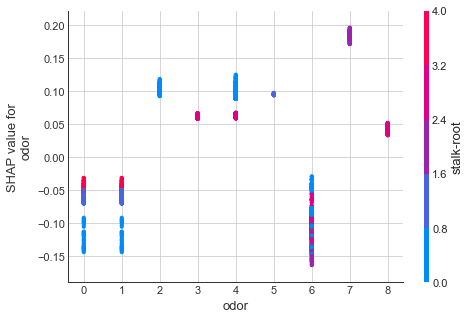

In [157]:
# Create a SHAP dependence plot to show the effect of a single feature across the whole dataset

shap.dependence_plot('odor', shap_values_1, df)

- Since **SHAP values** represent a **feature's responsibility for a change in the model output**, the plot above represents the **change in class of mushroom** as **odor changes**. 
<br><br>
  - **Vertical dispersion** at a single value of **odor** represents **interaction effects** with **other features**. 
<br><br> 
  - To help **reveal** these **interactions dependence_plot automatically selects another feature for coloring**. 
<br><br> 
  - In this case **coloring** by **stalk-root highlights** that the **probablity** of **mushroom being poisonous** is **higher** when **odor** has a **value 7** (i.e. **odor = pungent**) and the **stalk-root** has a **value 2** (i.e. **stalk-root is equal**).

In [158]:
# To get the key value pairing for each column before and after Label Encoding of the dataset. Use the code below.
# Getting the index of stalk-root column.

list(df.columns).index('stalk-root')

10

In [159]:
# Printing the values after Label Encoding with the original values of stalk-root.

for k, v in enumerate(categorical_names[10]):
    print(k, v)

0 bulbous
1 club
2 equal
3 missing
4 rooted


In [160]:
list(df.columns).index('odor')

4

In [161]:
for k, v in enumerate(categorical_names[4]):
    print(k, v)

0 almond
1 anise
2 creosote
3 fishy
4 foul
5 musty
6 none
7 pungent
8 spicy


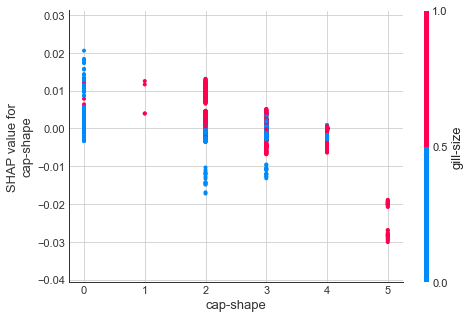

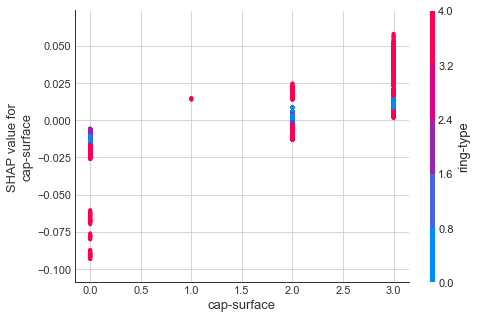

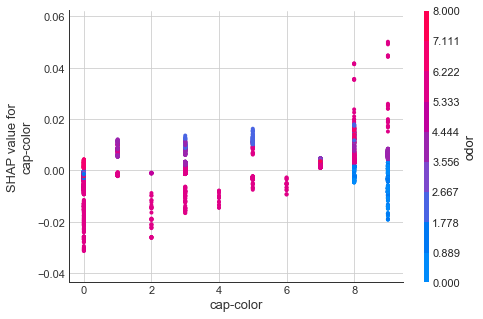

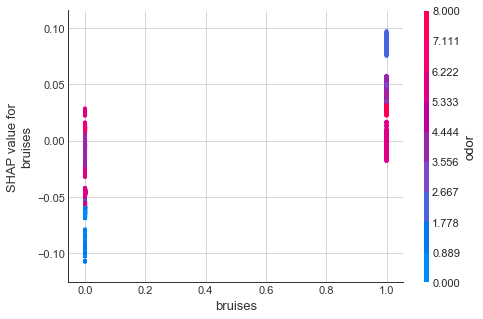

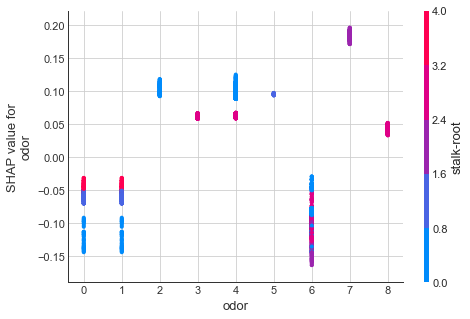

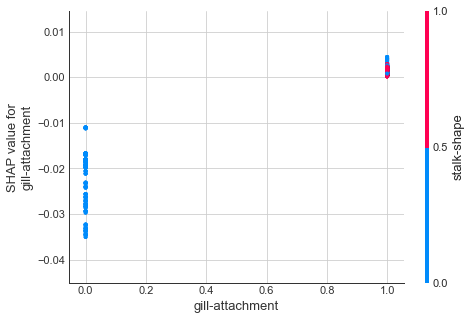

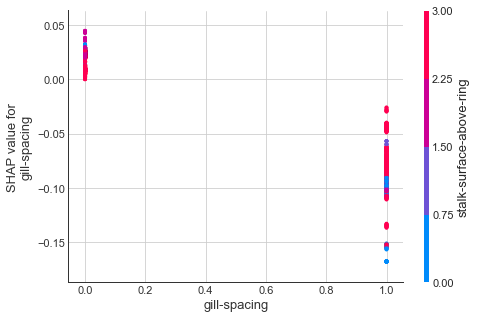

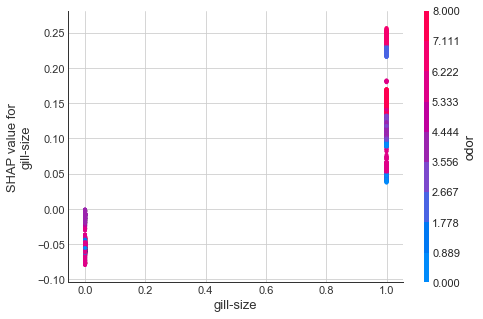

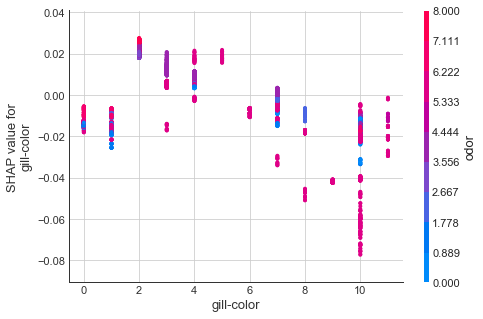

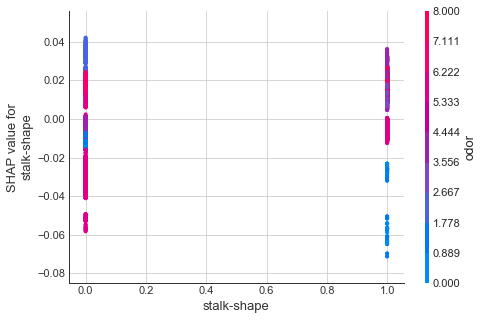

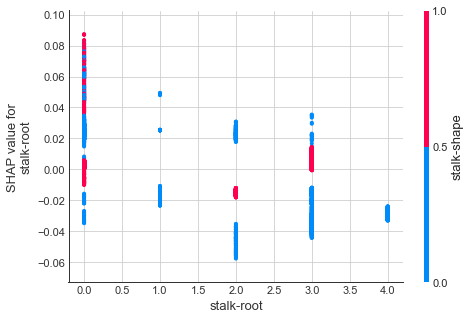

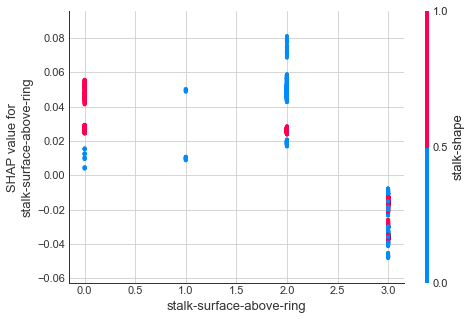

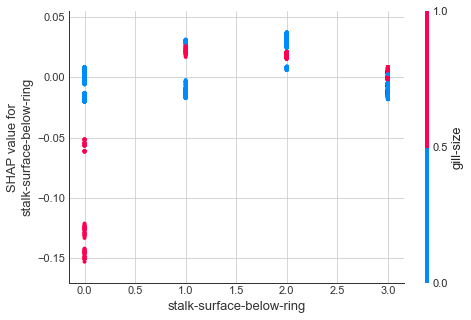

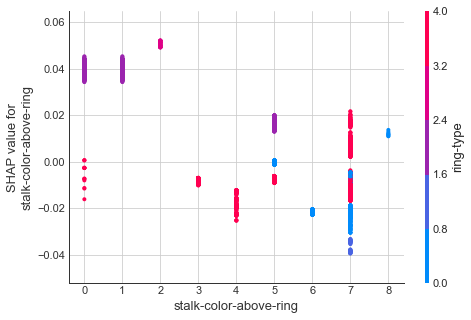

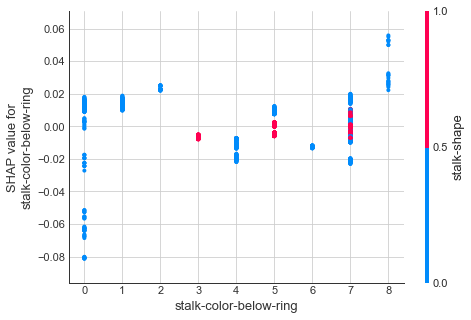

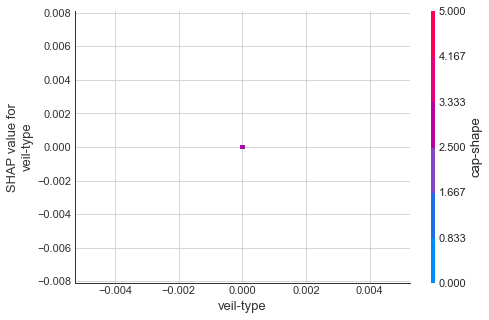

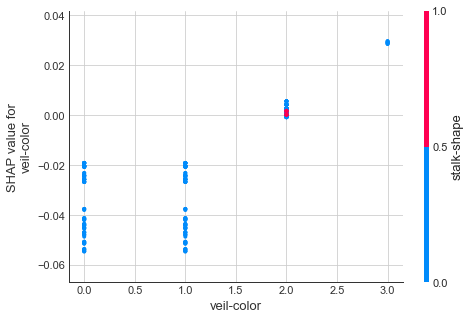

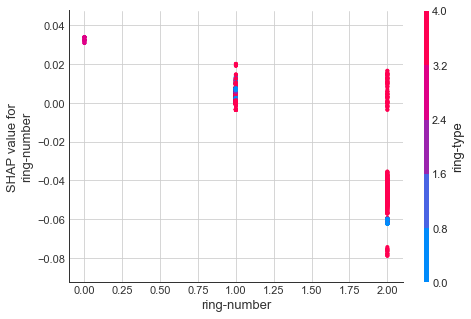

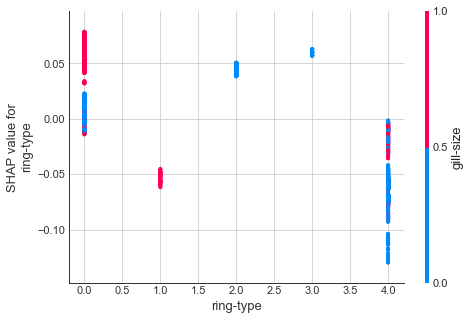

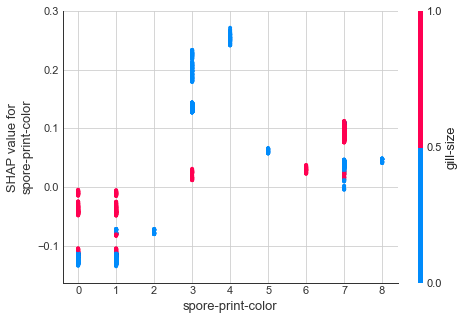

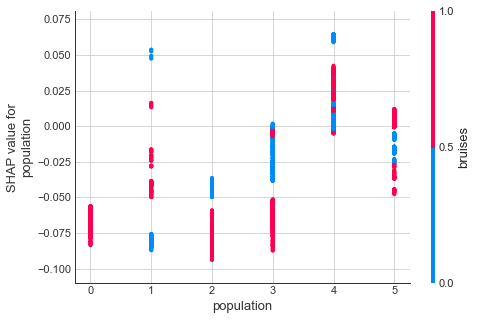

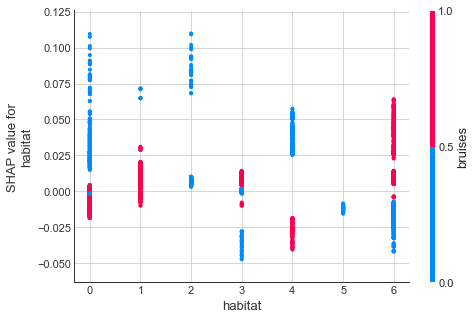

In [162]:
for name in df.columns:
    shap.dependence_plot(name, np.array(shap_values)[1, :, :], df)

- This shows us the method for **Plotting** the **Dependence Plots** for **each feature** in the dataset in a few lines of code.

<a id=section805></a>
### 8.5 SHAP Summary Plot

- To get an overview of **which features** are **most important for a model** we can **plot** the **SHAP values** of **every feature** for **every sample**. 


- We use a **density scatter plot** of **SHAP values** for **each feature to identify** how much **impact each feature has on the model output** for **individuals** in the **validation dataset**. 


- **Features** are **sorted** by the **sum of the SHAP value magnitudes** across all samples. 


- Note that when the **scatter points don't fit on a line** they **pile up to show density**, and the **color of each point represents** the **feature value of that individual**.

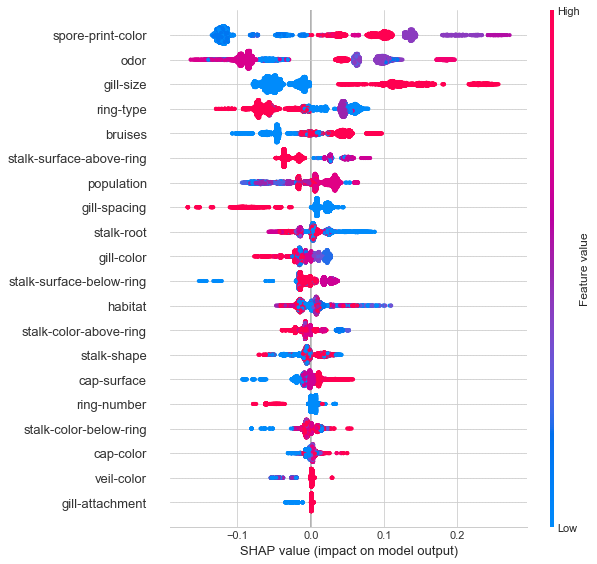

In [163]:
# Summarize the effects of all the features

shap.summary_plot(shap_values_1, df)

- The **plot** above **sorts features** by the **sum of SHAP value magnitudes over all samples**, and **uses SHAP values** to show the **distribution of the impacts each feature has on the model output**. 


- The **color represents the feature value (red high, blue low)**. 


- This **reveals** for example that for **spore-print-color** having **values "green"** and **"orange"**; and **odor** having **values "foul"** and **"pungent"** the **probability** of **mushroom** being **poisonous** is **higher**.

In [164]:
list(df.columns).index('spore-print-color')

19

In [165]:
for k, v in enumerate(categorical_names[19]):
    print(k, v)

0 black
1 brown
2 buff
3 chocolate
4 green
5 orange
6 purple
7 white
8 yellow


<a id=section806></a>
### 8.6 Bar chart of Mean Importance

- This takes the **average of the SHAP value magnitudes** across the dataset and **plots** it as a **simple bar chart**.

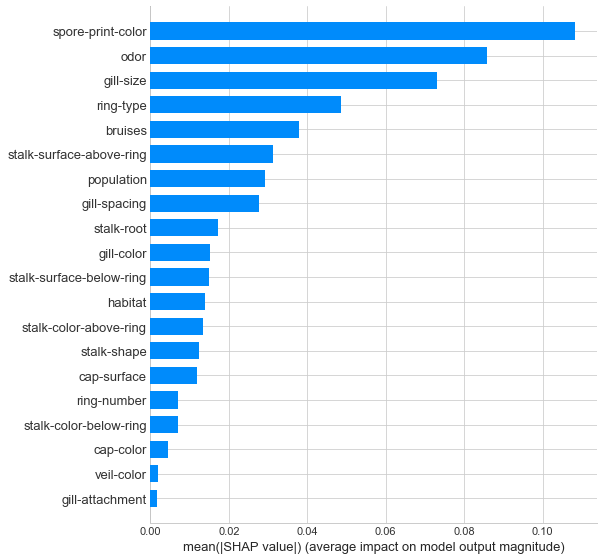

In [166]:
shap.summary_plot(shap_values_1, df_display, plot_type="bar")

- Here we can see that the **spore-print-color** column has the **highest feature importance** followed by **odor** column.


- This implies that the **spore print color** and **odor** of the **mushroom** are the **key indicators** in **identifying whether** a **mushroom** is **edible or poisonous**.